In [1]:
import os
import gc
import pickle
import numpy as np; np.random.seed(7)
import pandas as pd
import lightgbm as lgb
from tsforest.forecaster import LightGBMForecaster

import matplotlib.pyplot as plt
import seaborn as sns

# local modules
import sys
sys.path.append("../lib/")
from utils import compute_scaling, reduce_mem_usage, find_out_of_stock
from evaluation import Evaluator

/home/turing/miniconda/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


***

In [2]:
data = (pd.read_parquet("../input/train_dataframe.parquet")
        .reset_index(drop=True)
        .rename({"q":"y"}, axis=1)
       )

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45942500 entries, 0 to 45942499
Data columns (total 35 columns):
 #   Column             Dtype         
---  ------             -----         
 0   ts_id              int16         
 1   item_id            int16         
 2   dept_id            int8          
 3   cat_id             int8          
 4   store_id           int8          
 5   state_id           int8          
 6   y                  int16         
 7   ds                 datetime64[ns]
 8   event_name_1       int8          
 9   event_type_1       int8          
 10  event_name_2       int8          
 11  event_type_2       int8          
 12  sell_price         float32       
 13  n_prices           float32       
 14  regular_price      float32       
 15  price_iqr1         float32       
 16  price_iqr2         float32       
 17  price_min          float32       
 18  price_max          float32       
 19  discount           float32       
 20  discount_norm      flo

****

In [4]:
#weights_level12 = pd.read_parquet("../input/weights_level12.parquet")
#weights_level12.head()   

#scaling_input = pd.read_parquet("../input/scaling_input.parquet")
#scales = compute_scaling(scaling_input, agg_columns=["store_id","item_id"]).rename({"q":"s"}, axis=1)
#scales.head()

***
### finding time series with few samples

In [9]:
ts_with_few_samples = (data
                       .groupby(["item_id","store_id"])["ds"]
                       .count()
                       .reset_index(name="n_samples")
                       .query("n_samples < 29")
)
ts_with_few_samples.head()

,item_id,store_id,n_samples


In [ ]:
few_samples_data = (data
                    .merge(ts_with_few_samples.loc[:, ["item_id","store_id"]], how="left", indicator=True)
                    .query("_merge == 'both'")
                    .drop("_merge", axis=1)
                    .reset_index(drop=True)
                   )

In [6]:
data = (data
        .merge(ts_with_few_samples.loc[:, ["item_id","store_id"]], how="left", indicator=True)
        .query("_merge == 'left_only'")
        .drop("_merge", axis=1)
        .reset_index(drop=True)
       )

***

In [5]:
def make_valid_periods(end_date, valid_length, n_folds):
    right_date = pd.to_datetime(end_date)
    valid_periods = list()
    
    for i in range(n_folds):
        left_date = right_date - pd.DateOffset(days=valid_length-1)
        valid_periods.append((left_date, right_date))
        right_date = left_date - pd.DateOffset(days=1)
    
    return valid_periods[::-1]

In [6]:
#valid_periods = make_valid_periods("2016-04-24", valid_length=28, n_folds=13)
valid_periods = [(pd.to_datetime("2015-04-25"), pd.to_datetime("2015-05-22")),
                 (pd.to_datetime("2015-05-23"), pd.to_datetime("2015-06-19")), 
                 #(pd.to_datetime("2015-06-20"), pd.to_datetime("2015-07-17"))
                 #(pd.to_datetime("2016-03-28"), pd.to_datetime("2016-04-24"))
                ]
valid_periods

[(Timestamp('2015-04-25 00:00:00'), Timestamp('2015-05-22 00:00:00')),
 (Timestamp('2015-05-23 00:00:00'), Timestamp('2015-06-19 00:00:00'))]

***
## training

In [5]:
model_params = {
    'objective':'tweedie',
    'tweedie_variance_power': 1.1,
    'metric':'None',
    'num_iterations':100000,
    'early_stopping_rounds':200,
    'max_bin': 127,
    'bin_construct_sample_cnt':6000000,
    'num_leaves': 2**10-1,
    'min_data_in_leaf': 2**11-1,
    'learning_rate': 0.05, 
    #'min_sum_hessian_in_leaf':1e-4,
    'feature_fraction': 0.9,
    'bagging_fraction':0.66,
    'bagging_freq':1,
    'lambda_l2':0.1,
    'seed':7,
    'boost_from_average': False,
    'first_metric_only': False,
}

time_features = [
    "year",
    "month",
    "year_week",
    #"year_day",
    "week_day",
    "month_progress", 
    #"week_day_cos",
    #"week_day_sin",
    #"year_day_cos",
    #"year_day_sin",
    #"year_week_cos",
    #"year_week_sin",
    #"month_cos",
    #"month_sin"
]

exclude_features = [
                    #"regular_price",
                    #"discount",
                    #"discount_norm",
                    #"n_prices",
                    #"price_iqr1",
                    #"price_iqr2",
                    #"price_min",
                    #"price_max",
                    #"price_momentum_m",
                    #"price_momentum_y",
                    "ts_id",
                    "event_type_1",
                    "event_name_2",
                    "event_type_2"]

model_kwargs = {
    "model_params":model_params,
    "time_features":time_features,
    "lags": list(range(1,15)),
    "window_shifts":[1,7,28],
    "window_functions":["mean","std"],
    "window_sizes":[7,28],
    "exclude_features":exclude_features,
    "categorical_features":{#"ts_id":"default",
                            "item_id":"default", 
                            "dept_id":"default",
                            "cat_id":"default",
                            "store_id":"default",
                            "state_id":"default",
                            "event_name_1":"default", 
                            #"event_type_1":"default", 
                            #"event_name_2":"default", 
                            #"event_type_2":"default",
                            "snap":"default"},
    "ts_uid_columns":["item_id","store_id"]
}

***
### Training validation models

In [6]:
# 5 years of history
train_history = 1825

############################################### 1/2 ################################################
##### Validation period: (Timestamp('2015-04-25 00:00:00'), Timestamp('2015-05-22 00:00:00')) ######
####################################################################################################
[125]	valid_0's wrmsseL12: 0.67074	valid_0's wrmsse: 0.478053
[150]	valid_0's wrmsseL12: 0.67028	valid_0's wrmsse: 0.474916
[175]	valid_0's wrmsseL12: 0.669836	valid_0's wrmsse: 0.47107
[200]	valid_0's wrmsseL12: 0.669285	valid_0's wrmsse: 0.466421
[225]	valid_0's wrmsseL12: 0.66881	valid_0's wrmsse: 0.464207
[250]	valid_0's wrmsseL12: 0.668648	valid_0's wrmsse: 0.462126
[275]	valid_0's wrmsseL12: 0.668293	valid_0's wrmsse: 0.459753
[300]	valid_0's wrmsseL12: 0.668092	valid_0's wrmsse: 0.457755
[325]	valid_0's wrmsseL12: 0.667935	valid_0's wrmsse: 0.45915
[350]	valid_0's wrmsseL12: 0.667866	valid_0's wrmsse: 0.458993
[375]	valid_0's wrmsseL12: 0.667575	valid_0's wrmsse: 0.459509
[400]	val

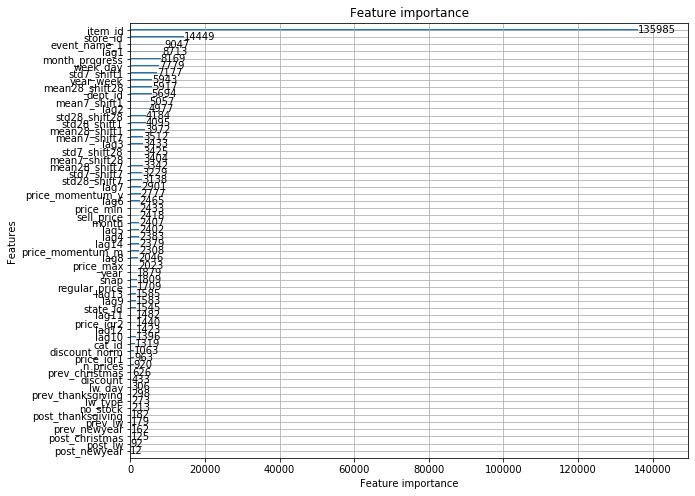

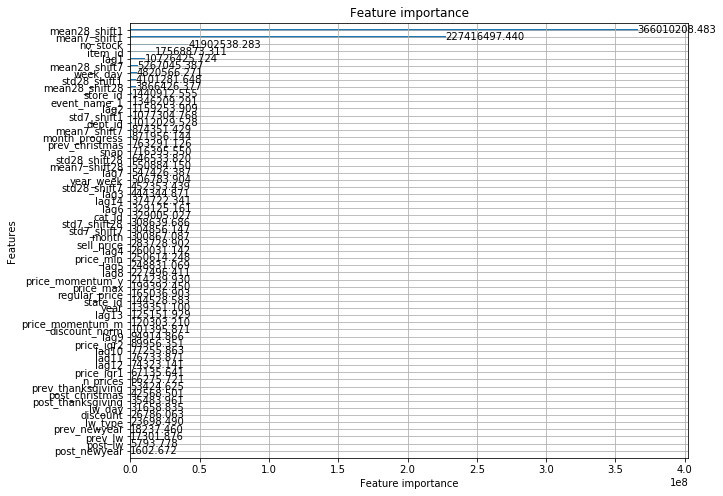

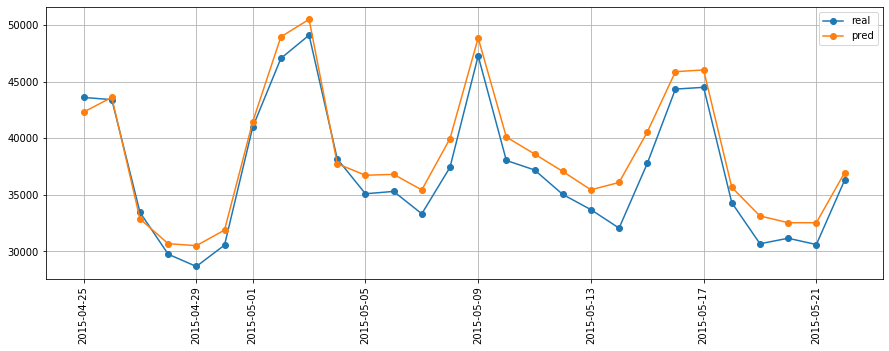

############################################### 2/2 ################################################
##### Validation period: (Timestamp('2015-05-23 00:00:00'), Timestamp('2015-06-19 00:00:00')) ######
####################################################################################################
Training until validation scores don't improve for 200 rounds
[25]	valid_0's wrmsseL12: 0.755212	valid_0's wrmsse: 0.9393
[50]	valid_0's wrmsseL12: 0.696584	valid_0's wrmsse: 0.66123
[75]	valid_0's wrmsseL12: 0.6882	valid_0's wrmsse: 0.616557
[100]	valid_0's wrmsseL12: 0.685681	valid_0's wrmsse: 0.594167
[125]	valid_0's wrmsseL12: 0.686218	valid_0's wrmsse: 0.586609
[150]	valid_0's wrmsseL12: 0.686215	valid_0's wrmsse: 0.582604
[175]	valid_0's wrmsseL12: 0.68576	valid_0's wrmsse: 0.576876
[200]	valid_0's wrmsseL12: 0.685508	valid_0's wrmsse: 0.573654
[225]	valid_0's wrmsseL12: 0.684737	valid_0's wrmsse: 0.570024
[250]	valid_0's wrmsseL12: 0.684323	valid_0's wrmsse: 0.567136
[275]	valid_0'

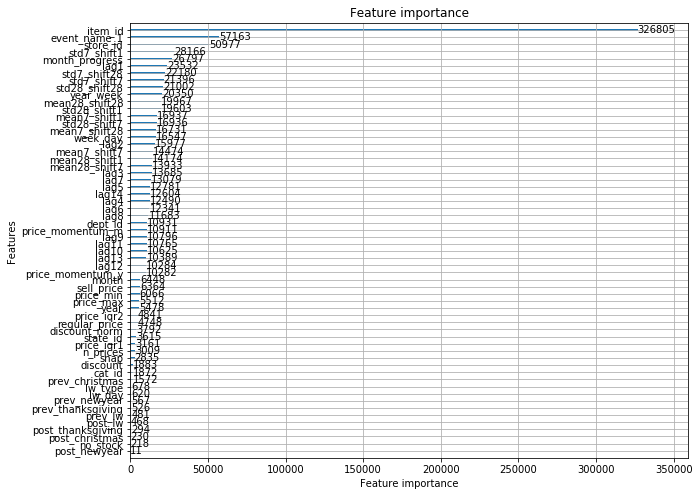

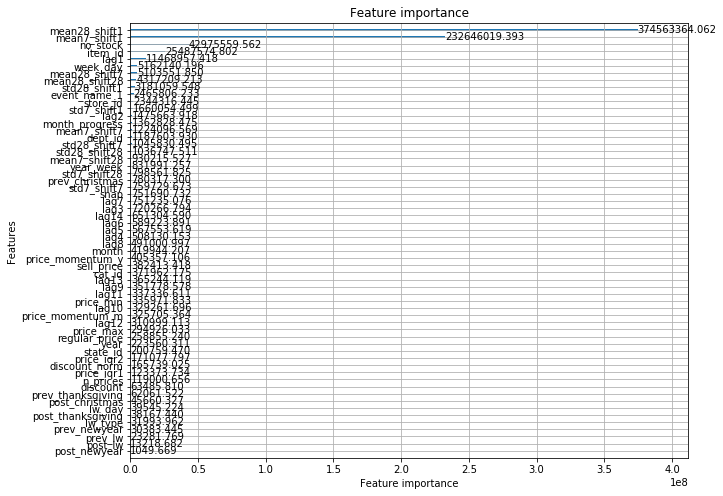

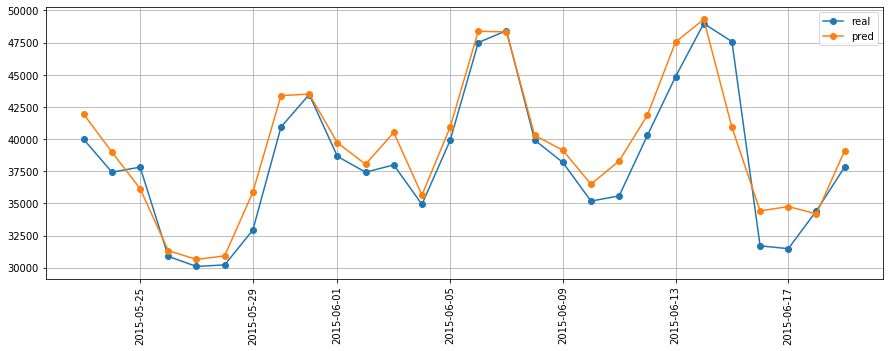

CPU times: user 21h 35min, sys: 2h 10min 58s, total: 23h 45min 58s
Wall time: 2h 43min 49s


In [9]:
%%time

models = list()
errors = list()
best_iterations = list()

for i,valid_period in enumerate(valid_periods):
    print(f" {i+1}/{len(valid_periods)} ".center(100, "#"))
    print(f" Validation period: {valid_period} ".center(100, "#"))
    print("#"*100)
    
    valid_start = valid_period[0]
    valid_end = valid_period[1]
    
    train_start = valid_start - pd.DateOffset(days=train_history)
    _train_data = data.query("@train_start <= ds <= @valid_end").reset_index(drop=True)
    _valid_index = _train_data.query("@valid_start <= ds <= @valid_end").index

    _fcaster = LightGBMForecaster(**model_kwargs)
    _fcaster.prepare_features(train_data=_train_data, valid_index=_valid_index);
    _fcaster.train_features.dropna(inplace=True)
    _fcaster.train_features = reduce_mem_usage(_fcaster.train_features)
    _fcaster.valid_features = reduce_mem_usage(_fcaster.valid_features)

    # needed to remove leakage of 'no_stock' feature
    no_stock_ts = list()
    for threshold in [28, 56, 84, 112, 140, 168]:
        left_date = _fcaster.train_features.ds.max() - pd.DateOffset(days=threshold)
        no_stock_ts.append((_fcaster.train_features
                            .query("ds >= @left_date")
                            .groupby(["ts_id"])
                            .filter(lambda x: np.all(x.y==0))
                            .loc[:, ["ts_id"]]
                            .drop_duplicates()))
    _fcaster.valid_features["no_stock"] = 0
    for j,no_stock in enumerate(no_stock_ts):
        idx = _fcaster.valid_features.query("ts_id in @no_stock.ts_id").index
        _fcaster.valid_features.loc[idx, "no_stock"] = j+1
    
    evaluator = Evaluator(_fcaster.valid_features)
    _fcaster.fit(fit_kwargs={"verbose_eval":25, "feval":evaluator.evaluate})

    lgb.plot_importance(_fcaster.model.model, importance_type="split", figsize=(10,8))
    lgb.plot_importance(_fcaster.model.model, importance_type="gain", figsize=(10,8))
    
    errors.append(_fcaster.model.model.best_score["valid_0"]["wrmsse"])
    best_iterations.append(_fcaster.best_iteration)
    
    # visualizing the predictions at level 1
    predictions = (_fcaster.valid_features
                   .loc[:, ["ds"]+_fcaster.ts_uid_columns]
                   .assign(y_pred = _fcaster.model.predict(_fcaster.valid_features))
                  )
    mrg =  (data.loc[:, ["ds","item_id","store_id","y"]]
            .merge(predictions, how="inner", on=["ds","item_id","store_id"]))
    df = mrg.groupby(["ds"])["y","y_pred"].sum().reset_index()
    
    print("RMSE:", np.sqrt(np.mean(df.eval("(y-y_pred)**2"))))
    print("RMSSE:", np.sqrt(np.mean(df.eval("(y-y_pred)**2")))/5926.0127)
    
    plt.figure(figsize=(15,5))
    plt.plot_date(df.ds, df.y, "o-", label="real")
    plt.plot_date(df.ds, df.y_pred, "o-", label="pred")
    plt.grid()
    plt.xticks(rotation=90)
    plt.legend(loc="best")
    plt.show()
    
    del _fcaster, evaluator, _train_data, _valid_index
    gc.collect()

In [3]:
print("min",int(np.min(best_iterations)))
print("mean", int(np.mean(best_iterations)))
print("max", int(np.max(best_iterations)))

NameError: name 'best_iterations' is not defined

In [11]:
np.mean(errors)

0.507456812194158

***
### final model

In [7]:
# 5 years of history
train_history = 1825

In [8]:
#model_kwargs["model_params"]["num_iterations"] = int(np.mean(best_iterations))
model_kwargs["model_params"]["num_iterations"] = 1000
model_kwargs["model_params"]

{'objective': 'tweedie',
 'tweedie_variance_power': 1.1,
 'metric': 'None',
 'num_iterations': 1000,
 'early_stopping_rounds': 200,
 'max_bin': 127,
 'bin_construct_sample_cnt': 6000000,
 'num_leaves': 1023,
 'min_data_in_leaf': 2047,
 'learning_rate': 0.05,
 'feature_fraction': 0.9,
 'bagging_fraction': 0.66,
 'bagging_freq': 1,
 'lambda_l2': 0.1,
 'seed': 7,
 'boost_from_average': False,
 'first_metric_only': False}

In [9]:
train_start = data.ds.max() - pd.DateOffset(days=train_history)
train_data = data.query("ds >= @train_start").reset_index(drop=True)

In [10]:
%%time
fcaster = LightGBMForecaster(**model_kwargs)
fcaster.prepare_features(train_data=train_data)
fcaster.train_features.dropna(inplace=True)
fcaster.train_features = reduce_mem_usage(fcaster.train_features)

CPU times: user 16min 1s, sys: 9min 35s, total: 25min 37s
Wall time: 25min 37s


In [11]:
# sanity check
len(fcaster.train_features.loc[:, fcaster.ts_uid_columns].drop_duplicates())

30490

In [12]:
%%time
fcaster.fit(fit_kwargs={"verbose_eval":20})

CPU times: user 12h 58min 17s, sys: 58min 29s, total: 13h 56min 47s
Wall time: 43min 16s


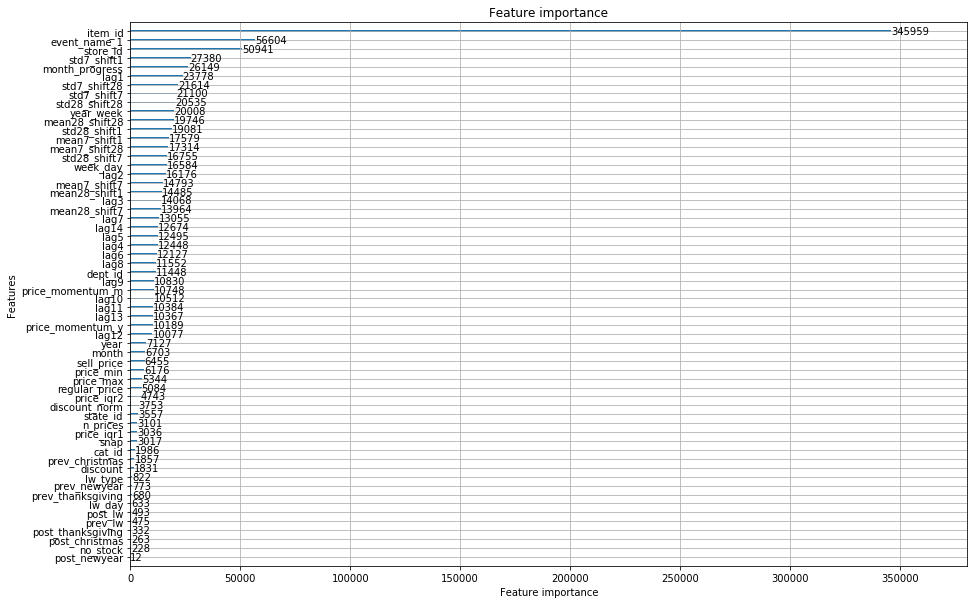

In [13]:
lgb.plot_importance(fcaster.model.model, importance_type="split", figsize=(15,10));

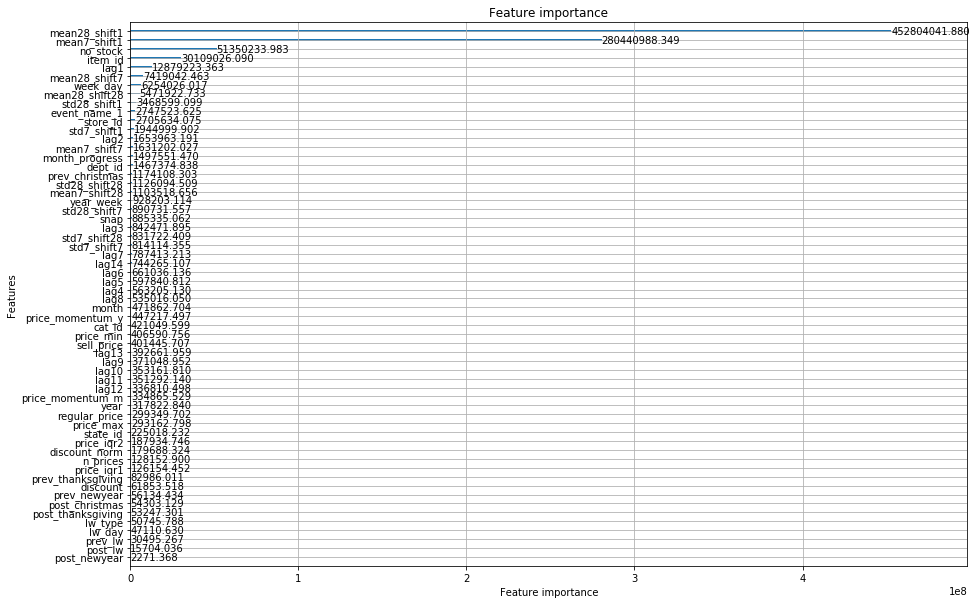

In [14]:
lgb.plot_importance(fcaster.model.model, importance_type="gain", figsize=(15,10));

***
### estimating residuals

In [43]:
%%time
predict_columns = list(set(fcaster.train_data.columns) - {"y"})
_train_data = fcaster.train_data.groupby('ts_id').apply(lambda x: x.sample(frac=0.66))
predictions = fcaster.predict(_train_data.loc[:, predict_columns])

CPU times: user 5h 32min 8s, sys: 3min 28s, total: 5h 35min 37s
Wall time: 21min 57s


In [44]:
residual_variance = (pd.merge(_train_data, predictions, how="inner", on=["item_id","store_id","ds"])
                     .assign(residual = lambda x: x.y - x.y_pred)
                     .groupby(["item_id","store_id"])["residual"].std()
                     .reset_index())
residual_variance

,item_id,store_id,residual
0,1,1,0.828616
1,1,2,0.838983
2,1,3,0.960896
3,1,4,0.880222
4,1,5,0.593202
...,...,...,...
30485,3049,6,1.638456
30486,3049,7,2.125310
30487,3049,8,3.889966
30488,3049,9,2.057362


In [45]:
residual_variance.to_parquet("../output/residuals_lgbm_bottom_v72.parquet", index=False)

***
### predicting

In [15]:
valid_dataframe = pd.read_parquet("../input/valid_dataframe.parquet")
eval_dataframe = pd.read_parquet("../input/eval_dataframe.parquet")
hierarchy = pd.read_parquet("../input/hierarchy.parquet")
submission = pd.read_csv("../input/sample_submission.csv")

In [16]:
#valid_dataframe = pd.merge(valid_dataframe, weights, how="left")
#eval_dataframe = pd.merge(eval_dataframe, weights, how="left")

In [17]:
# if the ts has no sales in the past 8 weeks, will be marked as out-of-stock for the prediction period.
#left_date = data.ds.max() - pd.DateOffset(days=56)
#no_sales_ts = (data
#               .query("ds >= @left_date")
#               .groupby(["ts_id"])
#               .filter(lambda x: np.all(x.y==0))
#               .loc[:, ["ts_id"]]
#               .drop_duplicates()
#              )

In [18]:
#valid_dataframe = valid_dataframe.query("ts_id not in @no_sales_ts.ts_id")

In [19]:
#fcaster.input_features

***

In [20]:
%%time
predictions = fcaster.predict(valid_dataframe, recursive=True);

CPU times: user 1h 42min 21s, sys: 4min 29s, total: 1h 46min 51s
Wall time: 1h 23min 36s


***
### predictions for validation period

In [21]:
predictions_valid = pd.merge(predictions,
                             hierarchy.loc[:, ["id", "item_id", "store_id"]], 
                             how="left")
predictions_valid["id"] = predictions_valid.id.map(lambda x: x+"_validation")

In [22]:
predictions_valid.y_pred.describe()

count    853720.000000
mean          1.445769
std           3.062884
min           0.000072
25%           0.278804
50%           0.660598
75%           1.485187
max         193.232379
Name: y_pred, dtype: float64

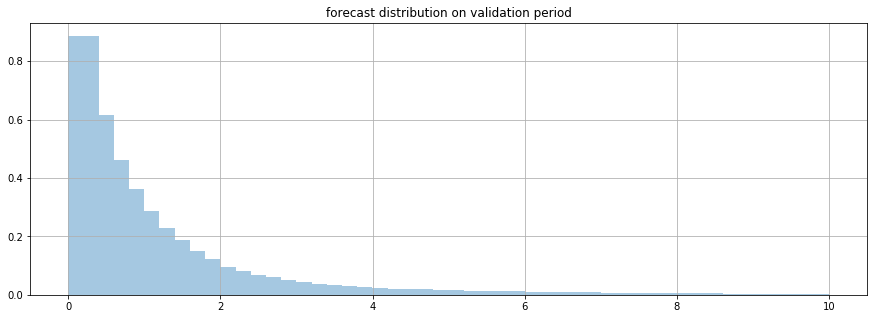

In [23]:
plt.figure(figsize=(15,5))
sns.distplot(predictions_valid.query("y_pred < 10").y_pred.values, kde=False, norm_hist=True)
plt.title("forecast distribution on validation period")
plt.grid()

In [24]:
predictions_valid = (predictions_valid
                     .pivot(index="id", columns="ds", values="y_pred")
                     .reset_index()
                     )
predictions_valid.columns = ["id"] + [f"F{i}" for i in range (1,29)]

***
### predictions for evaluation period

(ommited for now)

***
### submission file

In [35]:
assert set(predictions_valid.id) == set(submission.loc[0:30489].id), \
    "there are missing time series predictions."

In [25]:
submission = pd.merge(submission.loc[:, ["id"]], predictions_valid, how="left", on="id").fillna(0)

In [26]:
file_path = "../output/lgbm_bottom_v80.csv.gz"

if os.path.isfile(file_path):
    print("File already exists.")
else:
    submission.to_csv(file_path, index=False, compression="gzip")

In [27]:
!ls -halt ../output | grep .csv.gz | head -10

-rw-r--r--.  1 turing turing 7.5M May  5 22:23 lgbm_bottom_v80.csv.gz
-rw-r--r--.  1 turing turing 7.5M May  5 19:14 lgbm_bottom_v79.csv.gz
-rw-r--r--.  1 turing turing 7.5M May  5 10:45 lgbm_bottom_v78.csv.gz
-rw-r--r--.  1 turing turing 7.5M May  5 00:49 lgbm_bottom_v77.csv.gz
-rw-r--r--.  1 turing turing 7.5M May  4 21:18 lgbm_bottom_v76.csv.gz
-rw-r--r--.  1 turing turing 7.6M May  4 16:35 lgbm_bottom_v75.csv.gz
-rw-r--r--.  1 turing turing 7.6M May  4 09:47 lgbm_bottom_v74.csv.gz
-rw-r--r--.  1 turing turing  16M May  3 23:03 lgbm_bottom_v73.csv.gz
-rw-r--r--.  1 turing turing 7.5M May  3 20:51 lgbm_bottom_v72.csv.gz
-rw-r--r--.  1 turing turing 7.5M May  3 17:44 lgbm_bottom_v71.csv.gz


In [28]:
!kaggle competitions submit -c m5-forecasting-accuracy -f ../output/lgbm_bottom_v80.csv.gz -m ""

2020-05-05 22:23:31,915 WARNING Retrying (Retry(total=2, connect=None, read=None, redirect=None, status=None)) after connection broken by 'SSLError(SSLError("bad handshake: SysCallError(104, 'ECONNRESET')"))': /api/v1/competitions/m5-forecasting-accuracy/submissions/url/7859420/1588717406
2020-05-05 22:23:31,979 WARNING Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'SSLError(SSLError("bad handshake: SysCallError(104, 'ECONNRESET')"))': /api/v1/competitions/m5-forecasting-accuracy/submissions/url/7859420/1588717406
2020-05-05 22:23:32,119 WARNING Retrying (Retry(total=0, connect=None, read=None, redirect=None, status=None)) after connection broken by 'SSLError(SSLError("bad handshake: SysCallError(104, 'ECONNRESET')"))': /api/v1/competitions/m5-forecasting-accuracy/submissions/url/7859420/1588717406
Traceback (most recent call last):
  File "/home/turing/miniconda/lib/python3.7/site-packages/urllib3/contrib/pyopenssl.py", line 

***